In [1]:
import numpy as np
import pandas as pd
import ast #for strings
import re #regex

fname='MSCI446_ Data - Sheet1.csv'

def convert_to_numpy_array(string: str):
    # Verify string is written like a python list
    stripped = string.strip()
    pattern = r"\[(.*)\]"
    match = re.match(pattern, stripped)
    if not match:
        raise NotImplementedError(f"{stripped}")
    # Group 1 captures the content inside the square brackets
    contents = match.group(1)
    
    try:
        # Use ast.literal_eval to safely evaluate string literals
        evaluated = ast.literal_eval(stripped)
        if type(evaluated) is not list:
            raise NotImplementedError()
        # series = pd.Series(evaluated)
        return np.array(evaluated)
    except (SyntaxError, ValueError):  # this occurs with the "Condition" column
        # If parsing as a list fails, split the contents within the square brackets by comma, 
        # interpret each value as a string and strip whitespace
        return np.array([ item.strip() for item in contents.split(',') ])

# Read CSV file with the custom function
numerical_vector_column_labels = ['Temperature (F)', 'Dewpoint (F)', 'Humidity (%)', 'Wind Speed (mph)', 'Pressure (in)', 'Percipitation (in)']
categorical_vector_column_labels = ["Condition"]
vector_column_labels = numerical_vector_column_labels + categorical_vector_column_labels

# Create a converters dictionary mapping each column to the converter function
converters = {col: convert_to_numpy_array for col in vector_column_labels}
df = pd.read_csv(fname, converters=converters)
df.shape

(305, 13)

In [2]:
print(df)

           Fire Name  Year Season Started Locations Affected  \
0         Cagua Fire  2020         Winter             Aragua   
1      Vietnam Fires  2019         Summer            Da Nang   
2    Chile Wildfires  2024         Winter          O'Higgins   
3    Chile Wildfires  2024         Winter         Valparaíso   
4    Chile Wildfires  2023         Winter              Maule   
..               ...   ...            ...                ...   
300              NaN  2020         Summer                 MB   
301              NaN  2020         Summer                 MB   
302              NaN  2020           Fall                 MB   
303              NaN  2020         Summer                 NT   
304              NaN  2020         Summer                 NT   

                                      Temperature (F)  \
0    [75, 75, 73, 73, 72, 72, 71, 72, 72, 78, 82, 81]   
1    [79, 81, 81, 82, 84, 86, 88, 90, 91, 93, 95, 97]   
2    [78, 78, 78, 80, 82, 78, 77, 77, 77, 75, 73, 73]   
3  

## Checking Data

### Categorical Encoding

In [3]:
categorical_column_labels = ["Season Started", "Locations Affected", "Condition", "Type Of Location", "Y-Value"]
categorical_scalar_column_labels = ["Season Started", "Locations Affected", "Type Of Location", "Y-Value"]

In [4]:
for cl in categorical_scalar_column_labels:
    print(df[cl].value_counts())
    print()

Season Started
Summer    135
Spring     75
Fall       49
Winter     46
Name: count, dtype: int64

Locations Affected
California                23
MB                        19
BC                        19
AB                        18
Yellowknife               12
                          ..
North Rhine-Westphalia     1
South Holland              1
Hailey                     1
Yosemite National Park     1
Santa Rosa                 1
Name: count, Length: 110, dtype: int64

Type Of Location
Forest               77
Mountains            59
Hills                16
Arctic               11
Coastal Forest       10
Coastal Mountains    10
Rainforest            8
Flat                  8
Plains                6
Grasslands            6
Costal Mountain       5
Desert                4
Swamp                 3
Costal Forest         3
Coastal Hills         3
Coastal Lowland       2
Coastal Mountain      1
Mounatins             1
Costal Mountains      1
Coastal               1
Name: count, dtype: int64



### Vector Stuff

In [5]:
vector_columns = df[vector_column_labels]

In [6]:
# Verifying all are ndarray
is_ndarray = vector_columns.map(lambda x: isinstance(x, np.ndarray))
is_ndarray.all().all()

True

In [7]:
desired_shape = (12,)

shape = vector_columns.map(lambda x: x.shape)
# shape == desired_shape  # INVALID SYNTAX
is_desired_shape = shape.map(lambda x: x == desired_shape)

# Shorter version
is_desired_shape = vector_columns.map(lambda x: x.shape == desired_shape)

# Boolean series containing whether all vectors in that row are of the desired shape
valid_shape_rows = is_desired_shape.all(axis=1)

# Whether all vectors are of desired shape
is_desired_shape.all().all()

True

## Generating Stats

Generate minimum, average, and maximum values for specified columns

In [8]:
# Columns to generate stats for
columns_to_process = numerical_vector_column_labels

# Function to compute min, avg, and max and return as a Series
def compute_stats(arr):
    return pd.Series([np.min(arr), np.mean(arr), np.max(arr)], index=['min', 'avg', 'max'])

# New DataFrame to store results
new_df = pd.DataFrame()

# Iterate over specified columns
for col in df.columns:
    # If the column contains numpy arrays and is in the columns to process
    if col in columns_to_process:  # and np.issubdtype(df[col].dtype, np.ndarray)
        # Compute statistics for each numpy array element in the column
        stats = df[col].apply(compute_stats)
        # Rename columns to include the statistics
        stats.columns = [f"{col}_min", f"{col}_avg", f"{col}_max"]
        # Concatenate the statistics columns with the original column and insert them into the new DataFrame
        new_df = pd.concat([new_df, df[col], stats], axis=1)
    else:
        # If not a numpy array column or not in columns to process, copy it to the new DataFrame
        new_df[col] = df[col]

print(new_df)


           Fire Name  Year Season Started Locations Affected  \
0         Cagua Fire  2020         Winter             Aragua   
1      Vietnam Fires  2019         Summer            Da Nang   
2    Chile Wildfires  2024         Winter          O'Higgins   
3    Chile Wildfires  2024         Winter         Valparaíso   
4    Chile Wildfires  2023         Winter              Maule   
..               ...   ...            ...                ...   
300              NaN  2020         Summer                 MB   
301              NaN  2020         Summer                 MB   
302              NaN  2020           Fall                 MB   
303              NaN  2020         Summer                 NT   
304              NaN  2020         Summer                 NT   

                                      Temperature (F)  Temperature (F)_min  \
0    [75, 75, 73, 73, 72, 72, 71, 72, 72, 78, 82, 81]                 71.0   
1    [79, 81, 81, 82, 84, 86, 88, 90, 91, 93, 95, 97]                 79.0 

In [9]:
df = new_df

## Data Preparation

### 1. Dealing with missing values

Checking element values

In [10]:
# Only select for columns where we care if values are missing (do not care if we are missing Fire Name)
isna = df.loc[:, "Year":"Y-Value"].isna()
isna.sum()[isna.any()]
print(df.isna().sum())

# print(df['Type Of Location'].dtype)
# df = df.fillna('NaaN')
# df.drop(df[df['Type Of Location'] == 'NaaN'].index, inplace = True)
# print(df['Type Of Location'])

Fire Name                 150
Year                        0
Season Started              0
Locations Affected          0
Temperature (F)             0
Temperature (F)_min         0
Temperature (F)_avg         0
Temperature (F)_max         0
Dewpoint (F)                0
Dewpoint (F)_min            0
Dewpoint (F)_avg            0
Dewpoint (F)_max            0
Humidity (%)                0
Humidity (%)_min            0
Humidity (%)_avg            0
Humidity (%)_max            0
Wind Speed (mph)            0
Wind Speed (mph)_min        0
Wind Speed (mph)_avg        0
Wind Speed (mph)_max        0
Pressure (in)               0
Pressure (in)_min           0
Pressure (in)_avg           0
Pressure (in)_max           0
Percipitation (in)          0
Percipitation (in)_min      0
Percipitation (in)_avg      0
Percipitation (in)_max      0
Condition                   0
Type Of Location           70
Y-Value                     0
dtype: int64


Checking contents for numpy arrays (numerical only)

In [11]:
not df[numerical_vector_column_labels].map(lambda x: np.any(np.isnan(x))).any().any()

True

### 2. Dealing with duplicates

TBD

### 3. Dealing with categorical data

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [13]:
unencoded_df = df.copy(deep=True)

mapping_dict = {'BC': 'British Columbia', 'YT': 'Yukon', 'QC': 'Quebec', 'AB': 'Alberta', 'MB': 'Manitoba', 'ON': 'Ontario', 'CA': 'California'}
def pain(x) -> str:
    # create a temporary list to hold the replaced strings
    temp = []
    for word in str(x).split():
        temp.append(mapping_dict.get(word, word))
     
    # join the temporary list to create the final output string
    res = " ".join(temp)
    # print(temp, res)
    return str(res)

# Columns containing single categorical values
for cl in categorical_scalar_column_labels:
    if cl == 'Locations Affected':
        # print(unencoded_df['Locations Affected'].value_counts())
        df[cl] = df[cl].apply(pain)
        pass
    df[cl] = le.fit_transform(df[cl])

print(df['Condition'])

# Columns containing categorical vector values
for cl in categorical_vector_column_labels:
    le.fit(np.concatenate(df['Condition'].values))
    # le.fit_transform(df['Condition'])
    df[cl] = df[cl].apply(le.transform)
# print(df['Y-Value'].value_counts())
print(unencoded_df['Y-Value'].value_counts())
print(unencoded_df['Locations Affected'].value_counts())

0      [Fair, Fair, Partly Cloudy, Fair, Fair, Partly...
1      [Fair, Fair, Fair, Fair, Windy, Windy, Windy, ...
2      [Fair, Partly Cloudy, Mostly Cloudy, Fair, Par...
3      [Fair, Fair, Fair, Fair, Fair, Fair, Fair, Fai...
4      [Fair, Fair, Fair, Fair, Windy, Windy, Windy, ...
                             ...                        
300    [Fog, Partly Cloudy, Fair, Fair, Partly Cloudy...
301    [Thunder, Thunder, Thunder, Light Rain with Th...
302    [Cloudy, Mist, Cloudy, Cloudy, Light Rain, Clo...
303    [Mostly Cloudy, Mostly Cloudy, Partly Cloudy, ...
304    [Partly Cloudy, Fair, Fair, Fair, Fair, Fair, ...
Name: Condition, Length: 305, dtype: object
Y-Value
Fire        155
No Fire      93
Not Fire     57
Name: count, dtype: int64
Locations Affected
California                23
MB                        19
BC                        19
AB                        18
Yellowknife               12
                          ..
North Rhine-Westphalia     1
South Holland            

### 4. Dealing with Outliers

TBD

### 5. Partitioning a data set

Cross Validation

In [14]:
# Replace y value
with pd.option_context('future.no_silent_downcasting', True):
    fire_map = {'Fire': 1, 'Fire\r\n': 1, 'No Fire': 0, 'Not Fire': 0}
    coded_df = pd.DataFrame()
    coded_df['Y-Value_encoded'] = unencoded_df['Y-Value'].replace(fire_map).astype(int)
    coded_df['Y-Value_encoded'].value_counts()

In [15]:
# Replace seasons
# a = unencoded_df['Season Started'].unique()
# replace_dict = {k:v for v, k in enumerate(a)}
# print(replace_dict)
# coded_df['Season Started_enc'] = unencoded_df['Season Started'].replace(replace_dict)
coded_df['Season Started_enc'] = df['Season Started']
coded_df['Season Started_enc'].value_counts()

Season Started_enc
2    135
1     75
0     49
3     46
Name: count, dtype: int64

In [16]:
# Locations Affected
# print(df['Locations Affected'].value_counts())
b = df['Locations Affected'].unique()
print(len(b))
# replace_dict = {k:v for v, k in enumerate(b)}
# print(replace_dict)
# coded_df['Locations Affected_enc'] = unencoded_df['Locations Affected'].replace(replace_dict)
coded_df['Locations Affected_enc'] = df['Locations Affected']
coded_df['Locations Affected_enc'].value_counts()

104


Locations Affected_enc
3      30
14     27
17     26
41     22
101    12
       ..
12      1
22      1
30      1
38      1
84      1
Name: count, Length: 104, dtype: int64

In [17]:
coded_df['Type Of Location_enc'] = df['Type Of Location']
coded_df['Type Of Location_enc'].value_counts()

Type Of Location_enc
12    77
20    70
16    59
14    16
0     11
6     10
2     10
11     8
18     8
17     6
13     6
8      5
10     4
19     3
7      3
3      3
4      2
5      1
15     1
9      1
1      1
Name: count, dtype: int64

In [18]:
def str_to_list(x):
    test = ''
    if type(x) == type(test):
        values = x.replace(',','').replace('[','').replace(']','').split(' ')
        values = list(filter(None, values))
    else:
        values = x
    # Remove empty strings
    l = [float(val) for val in values]
    return l

def arr_to_intlist(x):
    l = [int(val) for val in x]
    return l

list_columns = numerical_vector_column_labels

added_cols = []

# First split numerical columns
for col in list_columns:
    if (df[col].dtype == 'object'):
        df[col] = df[col].apply(str_to_list if col != 'Condition' else arr_to_intlist)
    
    new_columns = [col + str(x) for x in range(12)]
    added_cols = added_cols + new_columns
    coded_df[new_columns] = pd.DataFrame(df[col].tolist(), columns=new_columns)
    print(coded_df[new_columns])


     Temperature (F)0  Temperature (F)1  Temperature (F)2  Temperature (F)3  \
0                75.0              75.0              73.0              73.0   
1                79.0              81.0              81.0              82.0   
2                78.0              78.0              78.0              80.0   
3                77.0              81.0              84.0              88.0   
4                72.0              73.0              73.0              73.0   
..                ...               ...               ...               ...   
300              54.0              57.0              59.0              64.0   
301              59.0              59.0              57.0              59.0   
302              37.0              37.0              37.0              37.0   
303              45.0              45.0              48.0              52.0   
304              63.0              64.0              66.0              70.0   

     Temperature (F)4  Temperature (F)5  Temperatur

In [19]:
from sklearn.model_selection import train_test_split

target_var = 'Y-Value_encoded'
feature_var = ['Season Started_enc', 'Locations Affected_enc', 'Type Of Location_enc'] + added_cols
X_train, X_test, y_train, y_test = train_test_split(coded_df[feature_var], coded_df[target_var], test_size=0.2, shuffle=True, random_state=101)

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold

repeatkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)

loo = LeaveOneOut()

kfold = KFold(n_splits=10, shuffle=True, random_state=6969)

model = GaussianNB()
model.fit(X_train, y_train) 

prediction = model.predict(X_test)

print('CV accuracy scores are', cross_val_score(model, X_train, y_train, scoring='accuracy', cv= kfold, n_jobs=-1))

print('The average KFold scores is', np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)))
print('The average LOOCV score is', np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=loo, n_jobs=-1)))
print('The average RepeatedKFold score is', np.mean(cross_val_score(model, X_train, y_train, cv=repeatkf, n_jobs=-1)))

CV accuracy scores are [0.48       0.8        0.72       0.72       0.66666667 0.5
 0.66666667 0.70833333 0.66666667 0.75      ]
The average KFold scores is 0.6678333333333334
The average LOOCV score is 0.6598360655737705
The average RepeatedKFold score is 0.6782057823129252


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Set parameter to be searched in a range
params = {'n_neighbors': range(1,150)}

# Initiate the KNN model and GridSearchCV function
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(estimator=knn, param_grid=params,
                        scoring='accuracy', cv=5)

# Fit the function to train set 
grid_knn.fit(X_train, y_train)

# Find the best parameter and see how well it performs on test set
print(grid_knn.best_params_)
print(grid_knn.score(X_test, y_test))
print(grid_knn.cv_results_['mean_test_score'])

{'n_neighbors': 31}
0.7868852459016393
[0.70501701 0.68860544 0.72534014 0.70909864 0.7172619  0.72534014
 0.7377551  0.72117347 0.72151361 0.7255102  0.7297619  0.73792517
 0.72159864 0.74209184 0.72568027 0.73401361 0.75442177 0.7462585
 0.74634354 0.7462585  0.75042517 0.75042517 0.75034014 0.75042517
 0.75034014 0.7545068  0.75442177 0.75442177 0.7585034  0.75841837
 0.76258503 0.76258503 0.7585034  0.75433673 0.7585034  0.7585034
 0.75442177 0.7585034  0.75442177 0.76258503 0.76258503 0.75841837
 0.7585034  0.7585034  0.75442177 0.75433673 0.7585034  0.75433673
 0.75433673 0.75841837 0.75841837 0.75841837 0.75841837 0.7625
 0.75841837 0.7625     0.75841837 0.7625     0.76258503 0.7585034
 0.7585034  0.7502551  0.7502551  0.7502551  0.7502551  0.75017007
 0.75433673 0.75017007 0.75433673 0.7542517  0.7502551  0.7502551
 0.7502551  0.7502551  0.7502551  0.7502551  0.74617347 0.75433673
 0.75841837 0.75017007 0.74608844 0.7420068  0.74617347 0.74209184
 0.74617347 0.74209184 0.742091

Bootstrapping

In [22]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

accuracy = []
n_iterations = 1000

for i in range(n_iterations):
    X_sparse, y_sparse = resample(X_test, y_test, replace=True)
    predict = model.predict(X_sparse)
    score = accuracy_score(y_sparse, predict)
    accuracy.append(score)

In [23]:
# Find median
median = np.median(accuracy)

# Find lower and upper bounds
lower = np.percentile(accuracy, 2.5)
upper = np.percentile(accuracy, 97.5)

print(f'The median is {median:.2f} '
      f'with confidence intervals of [{lower:.2f}, {upper:.2f}].')

The median is 0.69 with confidence intervals of [0.57, 0.80].


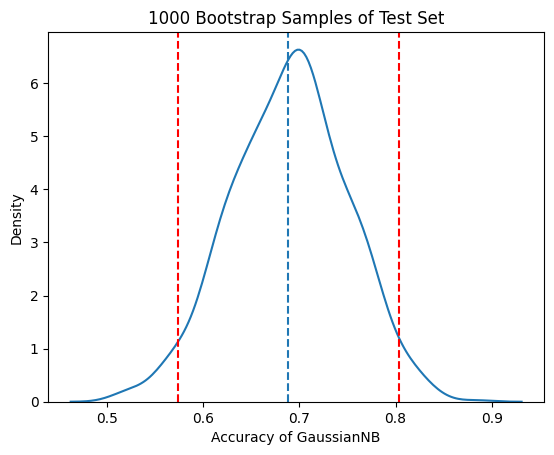

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(accuracy)
plt.title('1000 Bootstrap Samples of Test Set')
plt.xlabel('Accuracy of GaussianNB')
plt.axvline(median, 0, 16, linestyle="--")
plt.axvline(lower, 0, 16, linestyle="--", color="red")
plt.axvline(upper, 0, 16, linestyle="--", color="red")
plt.show()

### 6. Feature scaling

TBD

### 7. Data visualization

TBD